## FieldTrip sample data example
In this example we show processing of primate single unit data made available in FieldTrip spike tutorial (https://www.fieldtriptoolbox.org/tutorial/spike/).   

In [1]:
import os
import os.path as op

import numpy as np
import matplotlib.pyplot as plt

import pylabianca as pln

%load_ext autoreload
%autoreload 2

We will read fieldtrip sample data and perform similar analyses to the fieldtrip spike-analysis tutorial.  
[info on how files were processed - just read in fieldtrip and saved for spike data]  
[events - slightly preprocessed, removed "empty" events]  

In [2]:
data_dir = r'C:\Users\mmagnuski\Dropbox\Sarenka\PROJECTS\pylabianca\ft_data'
fname = 'p029_sort_final_01.mat'
full_path = op.join(data_dir, fname)

spk = pln.io.read_fieldtrip(full_path)

picks = [name for name in spk.cell_names if '_wf' in name]
spk.pick_cells(picks)

<Spikes, 7 cells, 302635.0 spikes/cell on average>

Let's see a simple text description of the file.

In [3]:
spk_ep = spk.to_epochs()

In [4]:
spk_ep.n_spikes()

array([157172,  38094, 336119, 164456, 887866, 134803, 399933])

In [ ]:
import numba

@numba.jit(nopython=True)
def _numba_spike_time_auto_distances(times, max_lag, dist_batch=):
    n_times = times.shape[0]
    distances = list()
    
    tm_idx_low = 0
    tm_idx_high = 1
    for idx1 in range(n_times):
        time1 = times[idx1]
        
        # move forward till tm_idx_high
        for idx2 in range(tm_idx_low, tm_idx_high):
            if not idx1 == idx2:
                distance = time1 - times[idx2]

                if distance < -max_lag:
                    tm_idx_low = idx2
                else:
                    distances.append(distance)

        max_lag_ok = True
        while max_lag_ok and idx2 < (n_times - 1):
            idx2 += 1
            distance = time1 - times[idx2]
            max_lag_ok = distance < max_lag
            
            if max_lag_ok:
                tm_idx_high = idx2
                distances.append(distance)

    return distances

In [5]:
# calc time diffs more efficiently
def _py_spike_time_auto_distances(times, max_lag, bins, batch_size=1_000):
    n_times = times.shape[0]
    distances = list()
    n_bins = len(bins) - 1
    counts = np.zeros(n_bins, dtype=int)
    
    tm_idx_low = 0
    tm_idx_high = 1
    in_batch = 0

    for idx1 in range(n_times):
        time1 = times[idx1]
        
        # move forward till tm_idx_high
        new_tm_idx_low = tm_idx_low
        for idx2 in range(tm_idx_low, tm_idx_high):
            if not idx1 == idx2:
                distance = time1 - times[idx2]

                if distance > max_lag:
                    new_tm_idx_low = idx2
                else:
                    distances.append(distance)
                    in_batch += 1

        tm_idx_low = new_tm_idx_low
        max_lag_ok = True
        while max_lag_ok and idx2 < (n_times - 1):
            idx2 += 1
            if not idx1 == idx2:
                distance = time1 - times[idx2]
                max_lag_ok = distance > -max_lag

                if max_lag_ok:
                    tm_idx_high = idx2
                    distances.append(distance)
                    in_batch += 1
        
        if in_batch >= batch_size or idx1 == (n_times - 1):
            these_counts, _ = np.histogram(distances, bins)
            counts += these_counts
            in_batch = 0
            distances = list()

    return counts

In [6]:
step = 0.01
bins = np.arange(-0.2, 0.2, step=step) + (step / 2)
times = spk_ep.time[1][:1000]
hist = _py_spike_time_auto_distances(times, 0.2, bins)

In [7]:
bins

array([-0.195, -0.185, -0.175, -0.165, -0.155, -0.145, -0.135, -0.125,
       -0.115, -0.105, -0.095, -0.085, -0.075, -0.065, -0.055, -0.045,
       -0.035, -0.025, -0.015, -0.005,  0.005,  0.015,  0.025,  0.035,
        0.045,  0.055,  0.065,  0.075,  0.085,  0.095,  0.105,  0.115,
        0.125,  0.135,  0.145,  0.155,  0.165,  0.175,  0.185,  0.195])

In [8]:
hist

array([ 95,  93,  82,  77,  78,  94,  86,  80,  78, 100, 108, 115, 111,
       103, 116, 113, 130, 166, 274,  74, 274, 166, 131, 112, 116, 103,
       111, 115, 108, 100,  78,  80,  86,  94,  78,  77,  82,  93,  95])

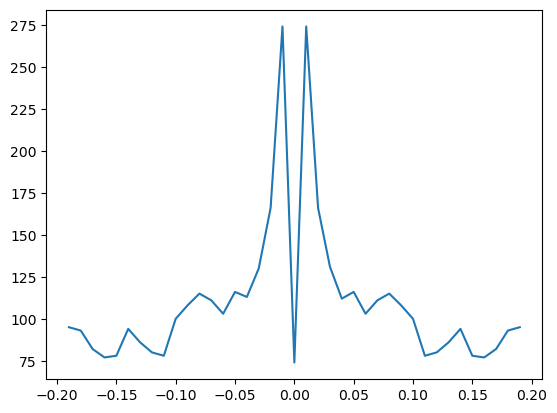

In [9]:
plt.plot(bins[:-1] + np.diff(bins) / 2, hist)

In [10]:
n_times = len(times)
dist = times[:, None] - times[None, :]
idx = np.diag_indices(n_times)
dist[idx] = np.nan
hist2, _ = np.histogram(dist.ravel(), bins)

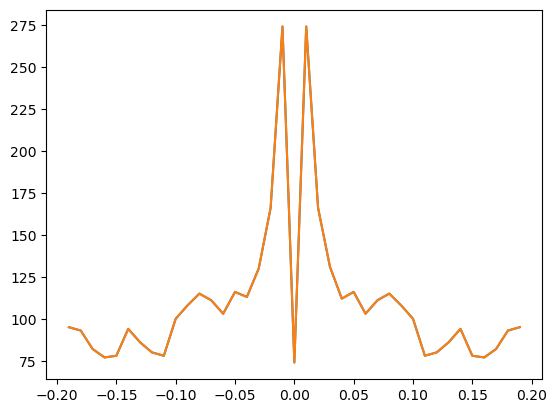

In [11]:
plt.plot(bins[:-1] + np.diff(bins) / 2, hist)
plt.plot(bins[:-1] + np.diff(bins) / 2, hist2)

In [12]:
hist == hist2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [13]:
dist = _numba_spike_time_auto_distances(spk_ep.time[1][:100], 0.2)

NameError: name '_numba_spike_time_auto_distances' is not defined

In [14]:
%timeit _py_spike_time_auto_distances(spk_ep.time[1][:1000], 0.2, bins)

3.11 ms ± 87.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%timeit _py_spike_time_auto_distances(spk_ep.time[1], 0.2, bins)

104 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%timeit _numba_spike_time_auto_distances(spk_ep.time[1][:1000], 0.2)

85.4 µs ± 4.47 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [16]:
step = 0.001
bins = np.arange(-0.2, 0.2, step=step) + (step / 2)

In [17]:
times_full = spk_ep.time[1]
hist_full = _py_spike_time_auto_distances(times_full, 0.2, bins)

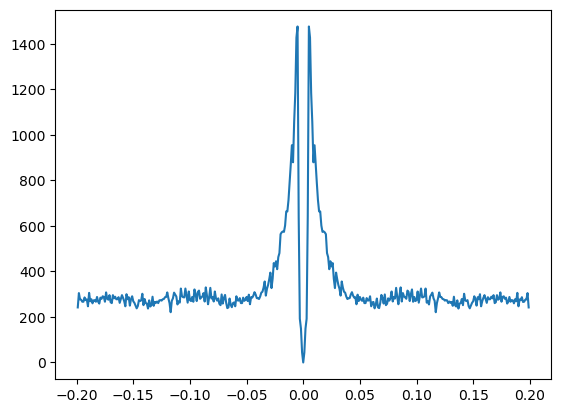

In [18]:
plt.plot(bins[:-1] + np.diff(bins) / 2, hist_full)